<img src="https://hilpisch.com/tpq_logo_bic.png" width="20%" align="right">


# Efficient Markets Hypothesis &mdash; Theory and Tests
## From EMH Story to Python Test Suite

&copy; Dr. Yves J. Hilpisch<br>
AI-Powered by GPT 5.x<br>
The Python Quants GmbH | https://tpq.io<br>
https://hilpisch.com | https://linktr.ee/dyjh


## Notebook Goals

This notebook turns the EMH note into an executable Python workflow using the
utilities in `markets/markets.py` and the shared end-of-day dataset
`https://hilpisch.com/eoddata.csv`.

We will

- load daily prices for several liquid instruments and compute log-returns,
- run weak-form efficiency diagnostics (autocorrelation, runs, variance
  ratios, simple predictability regressions),
- evaluate a toy out-of-sample AR(1) forecasting and trading exercise, and
- build an **efficiency scorecard** that summarizes diagnostics across
  multiple assets.

Throughout, EMH plays the role of a demanding null hypothesis: the tests here
are designed to stress that null rather than to guarantee tradeable alpha.


### Data and Environment

The empirical examples in this notebook rely on a small CSV file with daily
prices for a handful of liquid instruments (equity index, single stocks,
exchange-traded funds, FX, and Bitcoin). The canonical source is the remote
URL

- `https://hilpisch.com/eoddata.csv`

The same file is mirrored in the companion repository under
`markets/data/eoddata.csv` for offline use, but the code below always uses
the remote URL so that the notebook runs without local path adjustments.


In [1]:
import pathlib

if not pathlib.Path("markets.py").exists():
    !wget -q https://raw.githubusercontent.com/yhilpisch/cpfbridge/refs/heads/main/markets/markets.py -O markets.py

import numpy as np  # numerical arrays
import pandas as pd  # tabular data
import matplotlib.pyplot as plt  # plotting

import markets as emh  # EMH testing utilities

plt.style.use("seaborn-v0_8")  # basic plot style
plt.rcParams.update({
    "font.family": "serif",  # match note style
    "figure.dpi": 200,  # crisp figures
    "font.size": 9,  # compact base font
})

URL = "https://hilpisch.com/eoddata.csv"  # remote CSV with prices

def load_emh_prices(symbol: str = "SPY") -> pd.Series:
    """Return daily prices for a single symbol from the EMH CSV.

    Parameters
    -----
    symbol: str
        Column name in the CSV (for example "SPY" or "AAPL").
    """
    df = pd.read_csv(
        URL,
        index_col="Date",
        parse_dates=["Date"],
    )  # load remote CSV
    prices = df[symbol].dropna()  # pick one instrument
    prices.name = symbol  # label the series
    return prices


## 1. Prices, Returns, and Basic Diagnostics

We start with a single liquid instrument (by default `SPY`) to illustrate how
to move from prices to log-returns and a basic diagnostic summary.


patterns will later be replicated across several assets and combined into an
efficiency scorecard.


In [2]:
symbol = "SPY"  # choose a liquid asset

prices = load_emh_prices(symbol)  # daily prices
returns = emh.to_log_returns(prices)  # log-returns

diag = emh.diagnostics_summary(returns)  # basic diagnostics
pd.Series(diag)


mean          0.000539
vol           0.011409
skew         -0.598473
kurt         14.910050
n_obs      2514.000000
n_zeros       6.000000
dtype: float64

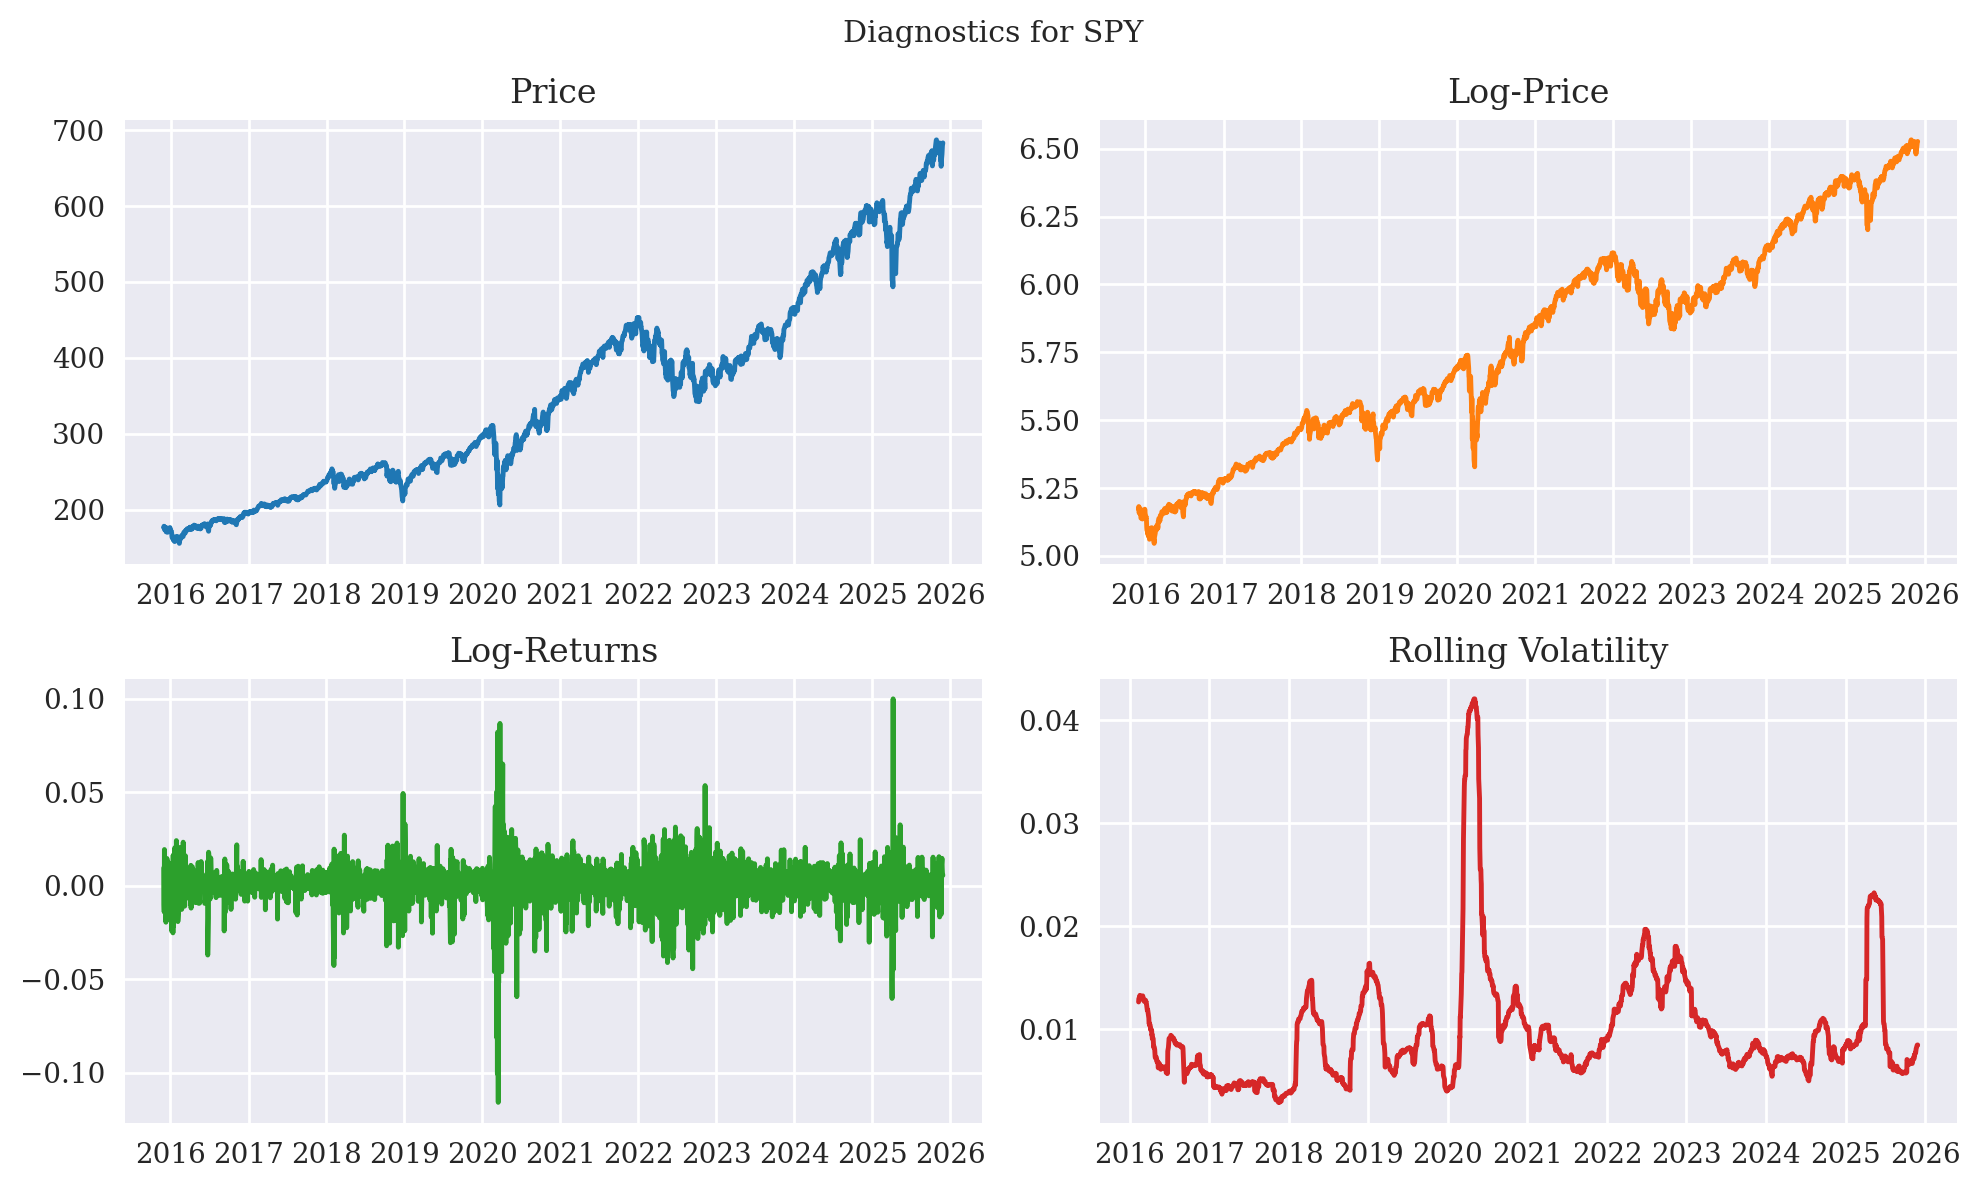

In [3]:
emh.plot_suite(prices, returns, title=f"Diagnostics for {symbol}")


## 2. Autocorrelation Diagnostics and Runs Test

The first weak-form checks focus on linear and sign-based dependence in
returns:

- autocorrelation up to a small number of lags, summarized via
  Ljung-Box statistics, and
- a runs test on the signs of returns.

For the Ljung-Box output, the key columns are the autocorrelations and the
p-values (`lb_pvalue`). As a rough rule of thumb:

- p-values above 5% suggest that autocorrelations up to the chosen lag are
  not statistically distinguishable from zero,
- very small p-values (for example below 1%) indicate a rejection of the
  joint null of zero autocorrelation, and
- in either case, the *magnitude* of the autocorrelations matters for
  economic relevance: values near 0.01 or 0.02 rarely support tradeable
  strategies once costs are included.

For the runs test, the z-statistic is approximately standard normal under the
null. Values beyond about 2 in absolute value correspond to p-values below
roughly 5%. Negative z-values indicate too few runs (trend-like behavior),
while positive values indicate too many runs (sign-level mean reversion).


In [5]:
acf_lb = emh.acf_ljungbox(returns, lags=(10, 20))  # ACF and Ljung-Box
acf_lb.round(4)


,acf,lb_stat,lb_pvalue
lag,,,
10,-0.0398,213.5338,0.0
20,-0.0086,258.2367,0.0


In [6]:
runs = emh.runs_test(returns)  # simple runs test on signs
runs


{'z_stat': 1.5220754922298938, 'p_value': 0.1279901660011955}

## 3. Variance Ratio Diagnostics

Variance ratio statistics compare the variance of $q$-period returns to
the variance implied by a random-walk model. Values near one are consistent
with a random walk; values above or below one suggest trend-like or
mean-reverting behavior, respectively.

In the table printed below, each row corresponds to a horizon $q$. As a
guideline:

- $\mathrm{VR}(q)$ close to 1 (for example between 0.9 and 1.1) is broadly
  in line with a random-walk benchmark,
- values meaningfully above 1, especially when stable across horizons, point
  towards trend-like behavior, and
- values meaningfully below 1 point towards mean reversion.

Formal variance ratio tests would attach standard errors or p-values; here we
focus on reading the pattern across horizons rather than relying on a single
threshold.


In [7]:
vr = emh.variance_ratio(returns, q_list=(2, 5, 10, 20))
vr


,vr,n_eff
q,,
2,0.851927,1257
5,0.745661,502
10,0.820892,251
20,0.853387,125


## 4. Simple Predictability Regression

We next estimate a one-lag autoregression of returns,
$r_{t+1} = \alpha + \beta r_t + \varepsilon_{t+1}$, and compute
heteroskedasticity-aware (HAC) standard errors. Under weak-form efficiency,
we expect $\beta$ to be small relative to its sampling error and the
R-squared to be modest.

In the summary printed below:

- `coef_lag_1` is the estimated $\beta$ and `p_lag_1` its p-value; values
  above 5% are consistent with the weak-form null of no linear
  predictability from the last return,
- even when the p-value is small, the *size* of the coefficient should be
  judged relative to transaction costs and typical volatility, and
- `r2` is usually tiny for daily returns; a very low R-squared is not a
  problem here, it is a reminder that most action is in volatility, not in
  conditional mean.


In [8]:
reg = emh.predictability_regression(returns, p=1, hac_lags=5)
reg[["coef_const", "coef_lag_1", "p_lag_1", "r2"]]


coef_const    0.000606
coef_lag_1   -0.132299
p_lag_1       0.029298
r2            0.017506
dtype: float64

## 5. Out-of-Sample AR(1) Forecasting and Toy Strategy

In-sample regressions can overstate predictability. To stress the EMH view
properly, we evaluate a simple rolling AR(1) forecasting strategy and
translate forecasts into positions via a sign rule. Net performance accounts
for a basic round-trip cost in basis points.

The resulting series printed below contains:

- `mse`: mean-squared forecast error relative to realized returns,
- `hit_rate`: fraction of days where the sign of the forecast matches the
  sign of the realized return (a naive benchmark is 50%),
- `gross_pnl`: cumulative sum of forecast-sign times returns, and
- `net_pnl`: the same after subtracting simple trading costs.

Out-of-sample gains that are small relative to volatility or disappear once
costs are included are better viewed as noise than as tradeable alpha.


In [9]:
oos = emh.oos_forecast_eval(returns, window=252, costs_bps=2.0)
pd.Series(oos)


mse          0.000136
hit_rate     0.501548
gross_pnl   -0.323670
net_pnl     -0.774670
dtype: float64

## 6. Efficiency Scorecard Across Assets

The final step aggregates diagnostics across several instruments into an
efficiency scorecard. This mirrors the summary tables described in the note
and provides a compact way to compare weak-form evidence across assets.

Each column in the transposed scorecard corresponds to a single asset and a
bundle of diagnostics. When reading it, focus on:

- whether Ljung-Box p-values (`lb_p_*`) stay comfortably above 5%,
- whether variance ratios (`vr_*`) are close to 1 or systematically above/
  below 1, and
- whether the out-of-sample AR(1) evaluation shows meaningful, positive
  `oos_net_pnl` and a hit rate materially above 50%.

Assets where most diagnostics look benign fall into the "consistent with
weak-form efficiency" bucket of the note. Assets where several diagnostics
line up, especially out-of-sample and after costs, move towards the
+    "potential inefficiency" bucket and warrant deeper investigation.


In [10]:
symbols = ["SPY", "AAPL", "EURUSD"]  # selection of instruments

ret_dict = {}  # container for log-return series
for sym in symbols:
    prices_sym = load_emh_prices(sym)  # prices for one symbol
    ret_dict[sym] = emh.to_log_returns(prices_sym)  # log-returns

scorecard = emh.efficiency_scorecard(ret_dict)  # build scorecard
scorecard.T.round(3)  # transpose for compact display


,SPY,AAPL,EURUSD
mean,0.001,0.001,0.000
vol,0.011,0.018,0.005
skew,-0.598,-0.088,0.247
kurt,14.910,6.624,1.968
n_obs,2514.000,2514.000,2202.000
n_zeros,6.000,6.000,17.000
acf_10,-0.040,-0.038,0.005
lb_p_10,0.000,0.000,0.315
acf_20,-0.009,-0.014,-0.016
lb_p_20,0.000,0.000,0.617


<img src="https://hilpisch.com/tpq_logo_bic.png" width="20%" align="right">
